In [1]:
import env
import numpy as np
import agents_gpu as agent
import copy
import torch as tr
from torch import nn
from matplotlib import pyplot as plt

C:\Users\NiSz\Anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ToM

## initialization

In [ ]:
%%time
n_agents = 2
agents = [agent.ExToMAgent(lr = 0.01, obs_shape = (11, 11, 4)) for i in range(n_agents)]
batch_size = 128
n_runs = 500

## Run training

In [ ]:
%%time
rewardss = []
ws = []
for i in range(n_runs):
    envs = [env.GridWorld(size = 11, n_target = 4) for i in range(batch_size)]
    ws.append(copy.deepcopy(agents[0].policy.fc.weight.cpu().detach())) 
    state = np.zeros([batch_size, 2, 11, 11, 4])
    for ie, e in enumerate(envs): # initial env
        e.reset()
        state[ie] = e.observe()
    observes = [state[:, ia, :, :, :].transpose([0, 3, 1, 2]) for ia in range(n_agents)]
    re = []
    
    for istep in range(10):
        act = [agents[ia].act(observes[ia]) for ia in range(n_agents)]
        
        state = np.zeros([batch_size, n_agents, 11, 11, 4])
        rewards = np.zeros([batch_size])
        dones = np.zeros([batch_size])
        for ie, e in enumerate(envs):
            _state, reward, done = e.step([act[ia][ie, 0].item() for ia in range(n_agents)])
            state[ie,:,:,:,:] = _state
            rewards[ie] = reward
            dones[ie] = done
        observes = [state[:, ia, :, :, :4].transpose([0, 3, 1, 2]).copy() for ia in range(n_agents)]
        re.append(np.mean(rewards))

        for ia in range(n_agents):
            agents[ia].record(rewards, observes[ia], dones)
            agents[ia].train_policy()
        if agents[0].trainingprocess==1:
            history_states, trajectories = [], []
            for ie in range(batch_size):
                _history_states, _trajectories = envs[ie].recall()
                history_states.append(_history_states)
                trajectories.append(_trajectories)
            history_obs = np.concatenate(history_states)
            trajectories = np.concatenate(trajectories)
            for ia in range(n_agents):
                obs = history_obs[:, ia, :, :, :][:, :, :, [0, 1, 3]].transpose([0, 3, 1, 2]).copy()
                traj = trajectories[:,:,:,ia]
                for j in range(round(10)):
                    agents[ia].train_ToMNet(obs, traj)
    for ia in range(n_agents):
        agents[ia].reset()
    rewardss.append(re)
    if i%10 ==0:
        if agents[0].trainingprocess==1:
            print("Epoch \t%d \t Reward %.2f \t ToM Loss %.5f"%(i, np.sum(rewardss[-1]), agents[0].ToMloss[-1]))
        else:
            print("Epoch \t%d \t Reward %.2f \t ToM Loss untrained"%(i, np.sum(rewardss[-1])))
    tr.cuda.empty_cache()
tr.save(agents[0].policy.state_dict(), 'PolicyNet_dict_ExToM.pt')
tr.save(agents[0].ToMNet.state_dict(), 'ToMNet_dict.pt')
np.save("ExToM.npy", ((agents[0].loss, agents[1].loss, agents[0].ToMloss, agents[1].ToMloss), rewardss), dtype=object)

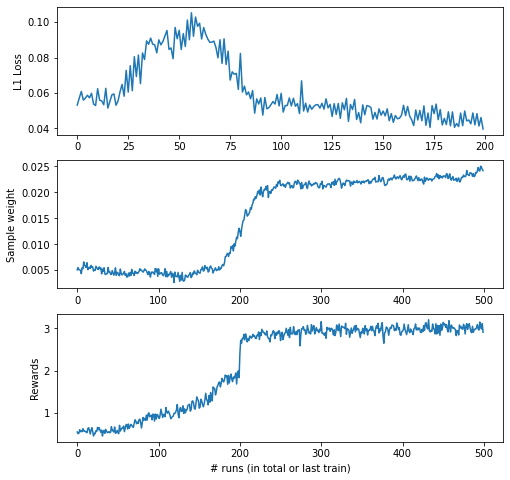

In [6]:
plt.figure(figsize=[8,8])
plt.subplot(3,1,1)
plt.plot(np.array(agents[0].loss).reshape([-1, 25]).mean(1))
plt.ylabel("L1 Loss")
#plt.ylim([-0,0.001])
plt.subplot(3,1,2)
plt.plot([ws[i][4,6].item() for i in range(len(rewardss))])
plt.ylabel("Sample weight")
plt.subplot(3,1,3)
plt.plot(rewardss)
plt.ylabel("Rewards")
plt.xlabel("# runs (in total or last train)")
plt.savefig("loss.svg")

# No ToM Train

## initialization

In [32]:
%%time
n_agents = 2
agents = [agent.ExToMAgent(lr = 0.01, obs_shape = (11, 11, 4)) for i in range(n_agents)]
batch_size = 128
n_runs = 500

Wall time: 35.9 ms


## Run training

In [34]:
%%time
rewardss = []
ws = []
for i in range(n_runs):
    envs = [env.GridWorld(size = 11, n_target = 4) for i in range(batch_size)]
    ws.append(copy.deepcopy(agents[0].policy.fc.weight.cpu().detach())) 
    state = np.zeros([batch_size, 2, 11, 11, 4])
    for ie, e in enumerate(envs): # initial env
        e.reset()
        state[ie] = e.observe()
    observes = [state[:, ia, :, :, :].transpose([0, 3, 1, 2]) for ia in range(n_agents)]
    re = []
    
    for istep in range(10):
        act = [agents[ia].act(observes[ia]) for ia in range(n_agents)]
        
        state = np.zeros([batch_size, n_agents, 11, 11, 4])
        rewards = np.zeros([batch_size])
        dones = np.zeros([batch_size])
        for ie, e in enumerate(envs):
            _state, reward, done = e.step([act[ia][ie, 0].item() for ia in range(n_agents)])
            state[ie,:,:,:,:] = _state
            rewards[ie] = reward
            dones[ie] = done
        observes = [state[:, ia, :, :, :4].transpose([0, 3, 1, 2]).copy() for ia in range(n_agents)]
        re.append(np.mean(rewards))

        for ia in range(n_agents):
            agents[ia].record(rewards, observes[ia], dones)
            agents[ia].train_policy()
    '''
    if agents[0].trainingprocess==1 and i%100 ==0:
        history_states, trajectories = [], []
        for ie in range(batch_size):
            _history_states, _trajectories = envs[ie].recall()
            history_states.append(_history_states)
            trajectories.append(_trajectories)
        history_obs = np.concatenate(history_states)
        trajectories = np.concatenate(trajectories)
        for ia in range(n_agents):
            obs = history_obs[:, ia, :, :, :][:, :, :, [0, 1, 3]].transpose([0, 3, 1, 2]).copy()
            traj = trajectories[:,:,:,ia]
            for j in range(round(1000)):
                agents[ia].train_ToMNet(obs, traj)
    '''
    for ia in range(n_agents):
        agents[ia].reset()
    rewardss.append(re)
    if i%10 ==0:
        if agents[0].trainingprocess==1 and False:
            print("Epoch \t%d \t Reward %.2f \t ToM Loss %.5f"%(i, np.sum(rewardss[-1]), agents[0].ToMloss[-1]))
        else:
            print("Epoch \t%d \t Reward %.2f \t ToM Loss untrained"%(i, np.sum(rewardss[-1])))
    tr.cuda.empty_cache()
tr.save(agents[0].policy.state_dict(), 'PolicyNet_dict_ExToM.pt')
tr.save(agents[0].ToMNet.state_dict(), 'ToMNet_dict.pt')
np.save("NoExToM.npy", ((agents[0].loss, agents[1].loss), rewardss), dtype=object)

Epoch 	0 	 Reward 2.56 	 ToM Loss untrained
Epoch 	10 	 Reward 2.63 	 ToM Loss untrained
Epoch 	20 	 Reward 2.74 	 ToM Loss untrained
Epoch 	30 	 Reward 2.68 	 ToM Loss untrained
Epoch 	40 	 Reward 2.62 	 ToM Loss untrained
Epoch 	50 	 Reward 2.66 	 ToM Loss untrained
Epoch 	60 	 Reward 2.68 	 ToM Loss untrained
Epoch 	70 	 Reward 2.74 	 ToM Loss untrained
Epoch 	80 	 Reward 2.70 	 ToM Loss untrained
Epoch 	90 	 Reward 2.63 	 ToM Loss untrained
Epoch 	100 	 Reward 2.64 	 ToM Loss untrained
Epoch 	110 	 Reward 2.68 	 ToM Loss untrained
Epoch 	120 	 Reward 2.74 	 ToM Loss untrained
Epoch 	130 	 Reward 2.79 	 ToM Loss untrained
Epoch 	140 	 Reward 2.73 	 ToM Loss untrained
Epoch 	150 	 Reward 2.82 	 ToM Loss untrained
Epoch 	160 	 Reward 2.70 	 ToM Loss untrained
Epoch 	170 	 Reward 2.79 	 ToM Loss untrained
Epoch 	180 	 Reward 2.73 	 ToM Loss untrained
Epoch 	190 	 Reward 2.79 	 ToM Loss untrained
Epoch 	200 	 Reward 2.73 	 ToM Loss untrained
Epoch 	210 	 Reward 2.83 	 ToM Loss untrained

TypeError: _save_dispatcher() got an unexpected keyword argument 'dtype'